In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv(
    '/content/drive/MyDrive/datasets/crypto/btc/ready/ta_corr_01_fd.csv',
    parse_dates=True
    )
target_col = 'log_returns'
exclude_cols = ['Close', 'log_close']
df = df.set_index(['timestamp'])
df.index = pd.to_datetime(df.index)
df = df[['Close', 'log_close', 'log_returns']]
df

,Close,log_close,log_returns
timestamp,,,
2014-11-27,369.670013,5.912611,0.003523
2014-11-28,376.446991,5.930777,0.018166
2014-11-29,375.490997,5.928234,-0.002543
2014-11-30,378.046997,5.935019,0.006784
2014-12-01,379.244995,5.938182,0.003164
...,...,...,...
2023-05-29,27745.884766,10.230843,-0.012171
2023-05-30,27702.349609,10.229273,-0.001570
2023-05-31,27219.658203,10.211695,-0.017578


In [7]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:

from models.transformer.my_functrions import make_dataset

num_of_test = 42
horizon=14
#horizon=1
timestep=10

Xtrain, Ytrain, Xtest, Ytest, XVal, YVal, scaler = make_dataset(
  df, target_col='log_returns', exclude_cols=exclude_cols, timestep=timestep, ntest=num_of_test, horizon=horizon
)


num_features = Xtrain.shape[-1]

X.shape (3088, 21) Y.shape (3088,)


In [11]:
train_indexx = df.index <= train.index[-1]
test_index = ~train_indexx

train_indexx[:timestep + 1] = False

In [12]:
df['ShiftLogClose'] = df['log_close'].shift(1)
prev = df['ShiftLogClose']

In [14]:
last_train = train.iloc[-1]['log_close']

In [16]:
test_log_pass = df.iloc[-Ntest:]['log_close']

In [24]:
Xtrain.shape

(3067, 21)

In [27]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)

  one_step_train_name = f'{name} train with 1 step prediction'
  one_step_test_name = f'{name} test with 1 step prediction'
  multi_step_test_name = f'{name} test with multistep prediction'

  df.loc[train_indexx, one_step_train_name] = prev[train_indexx] + model.predict(Xtrain)
  df.loc[test_index, one_step_test_name] = prev[test_index] + model.predict(Xtest)

  multistep_predictions = []

  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    prediction = model.predict(last_x.reshape(1, -1))[0]
    multistep_predictions.append(prediction)
    last_x = np.roll(last_x, -1)
    last_x[-1] = prediction
  
  df.loc[test_index, multi_step_test_name] = last_train + np.cumsum(multistep_predictions)
  df.iloc[-100:][[
    'log_close',
    one_step_train_name,
    one_step_test_name,
    multi_step_test_name
  ]].plot(figsize=(15, 5))

One-step forecast: SVR
Test MAPE (multi-step): 0.02229213268784615


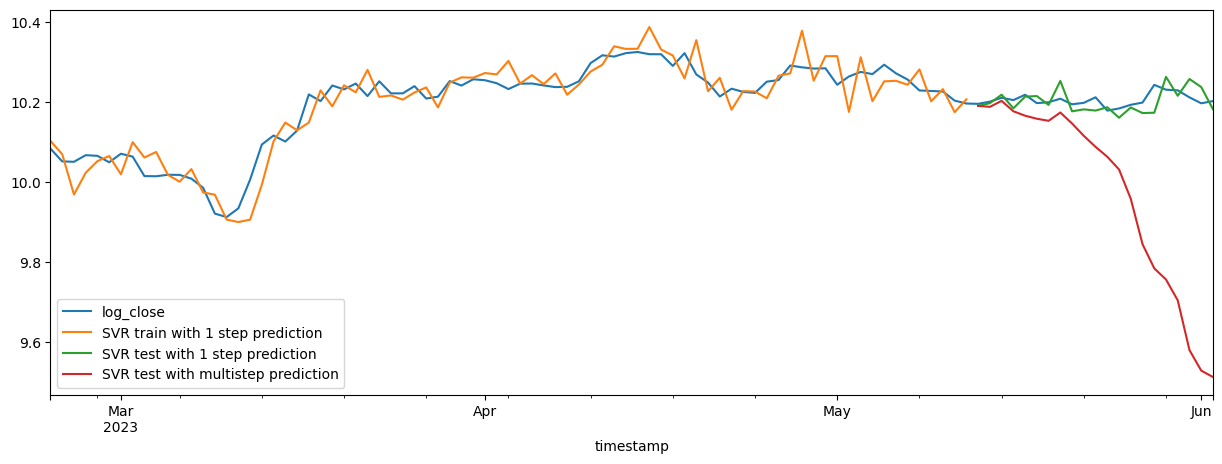

In [28]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: Random forest
Test MAPE (multi-step): 0.001536084899272749


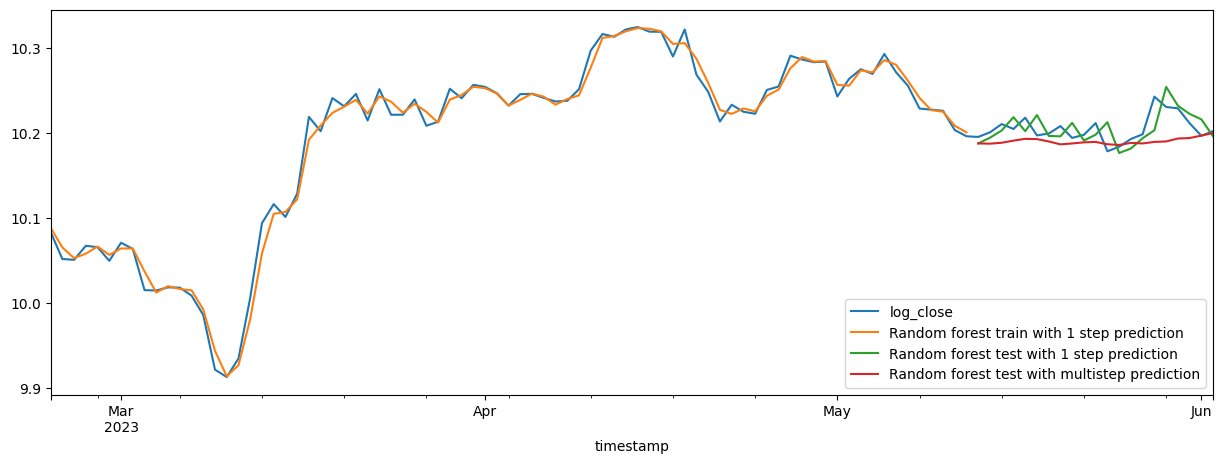

In [29]:
one_step_and_multistep_forecast(RandomForestRegressor(), "Random forest")